In [38]:
%matplotlib inline

import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score, classification_report, confusion_matrix
import collections
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc ,precision_recall_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

from mlxtend.classifier import StackingClassifier

In [26]:
# function to plot confusion matrix

def plot_confusion_matrix(test_y, pred_y):
    
    # calculating f1_score(micro) or accuracy
    print(f"f1_score :{metrics.f1_score(test_y, pred_y,average='micro')}")
    # calculating the number of data points that are misclassified
    print(f"Number of mis-classified points :{np.count_nonzero((pred_y- test_y))*100/test_y.shape[0]} %")

    C = metrics.confusion_matrix(test_y, pred_y)
    labels = [1,2,3,4,5,6,7,8]
    # representing in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Classification report", "-"*20)
    print(metrics.classification_report(test_y,pred_y,digits=3))
    
# function to plot precision-recall curve

def plot_precision_recall_curve(classifier,train_x,train_y,test_x,test_y,classes):
    # classes : array with the classes
    n_classes=len(classes)
    train_bin_y=label_binarize(train_y,classes)
    test_bin_y=label_binarize(test_y,classes)
    
    clf=OneVsRestClassifier(estimator=classifier)
    y_score=clf.fit(train_x,train_bin_y).predict_proba(test_x) 
    
    precision={}
    recall={}
    pr_auc={}
    for i in range(n_classes):
        precision[i], recall[i], threshpld_pr= precision_recall_curve(test_bin_y[:,i],y_score[:,i])
    
    fig, ax=plt.subplots(figsize=(16,7))
    ax.plot([0,1],[0,1],'k--')
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.05])
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision-Recall curve')
    for i in range(n_classes):
        ax.plot(recall[i], precision[i], label='class %i' %(classes[i]))
    ax.legend(loc="best")
    ax.grid(alpha=0.4)
    sns.despine()
    plt.show()
    
# function to plot ROC 

def plot_roc(classifier,train_x,train_y,test_x,test_y,classes):
    # classes : array with the classes
    n_classes=len(classes)
    train_bin_y=label_binarize(train_y,classes)
    test_bin_y=label_binarize(test_y,classes)
    
    clf=OneVsRestClassifier(estimator=classifier)
    y_score=clf.fit(train_x,train_bin_y).predict_proba(test_x) 
    
    fpr={}
    tpr={}
    roc_auc={}
    for i in range(n_classes):
        fpr[i], tpr[i], _= roc_curve(test_bin_y[:,i],y_score[:,i])
        roc_auc[i]= auc(fpr[i],tpr[i])
    
    fig, ax=plt.subplots(figsize=(16,7))
    ax.plot([0,1],[0,1],'k--')
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.05])
    ax.set_xlabel('false positive rate')
    ax.set_ylabel('true positive rate')
    ax.set_title('ROC')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area=%0.3f) for class %i' %(roc_auc[i],classes[i]))
    ax.legend(loc="best")
    ax.grid(alpha=0.4)
    sns.despine()
    plt.show()
    
# function to produce final result

def result(classifier, train_x, train_y, test_x, test_y, pred_y, classes):
    
    pred_train_y=classifier.predict(train_x)
    print("*"*30,"Train Set","*"*30)
    print("-"*20,"Classificarion Report","-"*20)
    print(metrics.classification_report(train_y,pred_train_y,digits=3))
    
    print("*"*30,'Evaluation on Test set',"*"*30)
    plot_confusion_matrix(test_y,pred_y)
    print("*"*30,"ROC","*"*30)
    plot_roc(classifier, train_x, train_y, test_x, test_y, classes)
    print("*"*30,'Precision-Recall curve',"*"*30)
    plot_precision_recall_curve(classifier, train_x, train_y, test_x, test_y, classes)

In [2]:
# function for new train set 
def new_x(*classifiers,x):
    new = pd.Series(dtype='int',name="drop")
    for i,clf in enumerate(classifiers):
        pred = pd.Series(clf.predict(x),dtype='int',name=(i+1))
        new = pd.concat([new,pred],axis=1)
    new=new.drop(columns=['drop'],axis=1)
    return new

In [3]:
# function to predict the output for stacking 

def test(x,y,classifier):
    svm = svm_clf.predict(x)
    lr = LR_clf.predict(x)
    rf = RF_clf.predict(x)
    et = ET_clf.predict(x)

    new_x = pd.DataFrame({'SVM':svm, 'LR':lr, 'RF':rf, 'ET':et})
    clf = classifier
    pred_y = clf.predict(new_x)
    print(f"f1_score:{f1_score(y, pred_y, average='micro')}")
    print("-"*30)
    print(f"classification report:\n{classification_report(y,pred_y,digits=3)}")
    return pred_y

### Data preparation

In [4]:
X_train = np.load('data/train/X_train.npy') 

Y_train = np.load('data/train/Y_train.npy')

X_test = np.load('data/test/set1/X_test.npy')

Y_test = np.load('data/test/set1/Y_test.npy')

X_test2 = np.load('data/test/set2/X_test2.npy')

Y_test2 = np.load('data/test/set2/Y_test2.npy')

X_dev = np.load('data/dev/X_dev.npy')

Y_dev = np.load('data/dev/Y_dev.npy')

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_test2 = scaler.fit_transform(X_test2)
X_dev = scaler.fit_transform(X_dev)

In [6]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)


print(X_test2.shape)
print(Y_test2.shape)

print(X_dev.shape)
print(Y_dev.shape)

(28368, 42)
(28368,)
(12168, 42)
(12168,)
(7040, 42)
(7040,)
(7040, 42)
(7040,)


In [7]:
#SVM_clf = joblib.load('models/svm_emg_clf.pkl')

LR_clf = joblib.load('models/LR_emg_clf.pkl')

RF_clf = joblib.load('models/RF_emg_clf.pkl')

ET_clf = joblib.load('models/ET_emg_clf.pkl')

C:\anaconda\envs\PratikEnv\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\anaconda\envs\PratikEnv\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\anaconda\envs\PratikEnv\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\anaconda\envs\PratikEnv\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.22.2.post1 when using version 0.22.1. This mi

In [8]:
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## meta clf: RF

In [9]:
lr = LR_clf.predict(X_dev)
rf = RF_clf.predict(X_dev)
et = ET_clf.predict(X_dev)

In [10]:
svm_clf = SVC(kernel='rbf', C=35.4, gamma='scale', class_weight='balanced', probability=True)
svm_clf.fit(X_train, Y_train)

SVC(C=35.4, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [11]:
svm = svm_clf.predict(X_dev)

In [12]:
new_train_x = pd.DataFrame({'SVM':svm, 'LR':lr, 'RF':rf, 'ET':et}) # make a new train set to tune RF

In [151]:
#new_train_x1=new_x(svm_clf,LR_clf,ET_clf,RF_clf,x=X_dev)

In [13]:
new_train_x.head()

,SVM,LR,RF,ET
0,6,6,6,6
1,1,1,1,1
2,3,3,3,3
3,4,4,4,4
4,7,7,7,7


### RF

In [12]:
# baseline prediction (to get the minimum score)

model1 = RandomForestClassifier()
model1.fit(new_train_x,Y_dev)
train_pred_y1 = model1.predict(new_train_x)

print(classification_report(Y_dev,train_pred_y1))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       889
           1       1.00      1.00      1.00       879
           2       1.00      1.00      1.00       889
           3       1.00      0.97      0.98       888
           4       1.00      1.00      1.00       883
           5       0.91      0.99      0.95       887
           6       0.98      0.92      0.95       877
           7       1.00      1.00      1.00       848

    accuracy                           0.98      7040
   macro avg       0.98      0.98      0.98      7040
weighted avg       0.98      0.98      0.98      7040



#### Hyperparameter tunning

In [14]:
para = {'n_estimators':[100,200,500],
    'max_depth':[5,10,15],
    'max_features':['auto','sqrt','log2']}

Rf = RandomForestClassifier(n_jobs=-1)

model = GridSearchCV(estimator = Rf, 
                      param_grid = para, 
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=5,
                      return_train_score=True,
                      verbose=1)
model.fit(new_train_x,Y_dev)
print(f"best parameters: {model.best_params_}")
print(f"best score: {model.best_score_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  1.1min finished


best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
best score: 0.9813920454545455


In [15]:
para = {'n_estimators':[100,200,500],
    'max_depth':[8,10,12],
    'max_features':['auto','sqrt','log2']}

Rf = RandomForestClassifier(n_jobs=-1)

model = GridSearchCV(estimator = Rf, 
                      param_grid = para, 
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=5,
                      return_train_score=True,
                      verbose=1)
model.fit(new_train_x,Y_dev)
print(f"best parameters: {model.best_params_}")
print(f"best score: {model.best_score_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  1.1min finished


best parameters: {'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}
best score: 0.9818181818181818


In [16]:
para = {'n_estimators':[150,200,250],
    'max_depth':[7,8,9],
    'max_features':['auto','sqrt','log2']}

Rf = RandomForestClassifier(n_jobs=-1)

model = GridSearchCV(estimator = Rf, 
                      param_grid = para, 
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=5,
                      return_train_score=True,
                      verbose=1)
model.fit(new_train_x,Y_dev)
print(f"best parameters: {model.best_params_}")
print(f"best score: {model.best_score_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   49.0s finished


best parameters: {'max_depth': 7, 'max_features': 'log2', 'n_estimators': 150}
best score: 0.9818181818181818


#### best model

In [14]:
model1 = RandomForestClassifier(n_estimators=200,max_depth=8,max_features='sqrt',random_state=100,n_jobs=-1)
model1.fit(new_train_x,Y_dev)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=100, verbose=0,
                       warm_start=False)

In [153]:
def test(x,y,classifier):
    svm = svm_clf.predict(x)
    lr = LR_clf.predict(x)
    rf = RF_clf.predict(x)
    et = ET_clf.predict(x)

    new_x = pd.DataFrame({'SVM':svm, 'LR':lr, 'RF':rf, 'ET':et})
    clf = classifier
    pred_y = clf.predict(new_x)
    print(f"f1_score:{f1_score(y, pred_y, average='micro')}")
    print("-"*30)
    print(f"classification report:\n{classification_report(y,pred_y,digits=3)}")
    return pred_y

In [15]:
pred_y1 = test(X_test,Y_test,model1)
pred_y2 = test(X_test2,Y_test2,model1)

f1_score:0.9583333333333334
------------------------------
classification report:
              precision    recall  f1-score   support

           0      0.979     0.999     0.989      1521
           1      0.999     1.000     0.999      1521
           2      0.995     0.999     0.997      1521
           3      0.973     0.840     0.902      1521
           4      1.000     0.999     0.999      1521
           5      0.846     0.959     0.899      1521
           6      0.890     0.870     0.880      1521
           7      1.000     1.000     1.000      1521

    accuracy                          0.958     12168
   macro avg      0.960     0.958     0.958     12168
weighted avg      0.960     0.958     0.958     12168

f1_score:0.9826704545454545
------------------------------
classification report:
              precision    recall  f1-score   support

           0      0.994     1.000     0.997       887
           1      1.000     1.000     1.000       883
           2      1.00

In [16]:
model2 = RandomForestClassifier(n_estimators=150,max_depth=7,max_features='log2',random_state=100,n_jobs=-1)
model2.fit(new_train_x,Y_dev)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=100, verbose=0,
                       warm_start=False)

In [17]:
pred_y11 = test(X_test,Y_test,model2)
pred_y22 = test(X_test2,Y_test2,model2)

f1_score:0.9576758711374096
------------------------------
classification report:
              precision    recall  f1-score   support

           0      0.979     0.999     0.989      1521
           1      0.999     1.000     0.999      1521
           2      0.995     0.999     0.997      1521
           3      0.972     0.835     0.898      1521
           4      1.000     0.999     0.999      1521
           5      0.844     0.959     0.898      1521
           6      0.888     0.870     0.879      1521
           7      1.000     1.000     1.000      1521

    accuracy                          0.958     12168
   macro avg      0.960     0.958     0.958     12168
weighted avg      0.960     0.958     0.958     12168

f1_score:0.9823863636363637
------------------------------
classification report:
              precision    recall  f1-score   support

           0      0.994     1.000     0.997       887
           1      1.000     1.000     1.000       883
           2      1.00

### model1 is better as expected

__________________________________________________________________________________________________________________

## checking with predefined StackingClassifier

In [25]:
from mlxtend.classifier import StackingClassifier

In [17]:
meta_rf = RandomForestClassifier(n_estimators=150,max_depth=7,max_features='log2',random_state=100,n_jobs=-1)
sclf = StackingClassifier(classifiers=[svm_clf, LR_clf, RF_clf, ET_clf], meta_classifier=meta_rf, use_probas=True)
sclf.fit(X_train, Y_train)
print("Stacking Classifer :f1_score: %f" % (f1_score(Y_dev, sclf.predict(X_dev), average='micro')))

Stacking Classifer :f1_score: 0.970597


In [18]:
pred1=sclf.predict(X_test)
pred2=sclf.predict(X_test2)

In [19]:
print("Stacking Classifer :f1_score Test1: %f" % (f1_score(Y_test, pred1, average='micro')))
print("Stacking Classifer :f1_score Test2: %f" % (f1_score(Y_test2, pred2, average='micro')))

Stacking Classifer :f1_score Test1: 0.923406
Stacking Classifer :f1_score Test2: 0.975142


In [20]:
meta_rf = RandomForestClassifier(n_estimators=200,max_depth=8,max_features='sqrt',random_state=100,n_jobs=-1)
sclf = StackingClassifier(classifiers=[svm_clf, LR_clf, RF_clf, ET_clf], meta_classifier=meta_rf, use_probas=True)
sclf.fit(X_train, Y_train)
print("Stacking Classifer :f1_score: %f" % (f1_score(Y_dev, sclf.predict(X_dev), average='micro')))

Stacking Classifer :f1_score: 0.971307


In [21]:
pred1=sclf.predict(X_test)
pred2=sclf.predict(X_test2)

print("Stacking Classifer :f1_score Test1: %f" % (f1_score(Y_test, pred1, average='micro')))
print("Stacking Classifer :f1_score Test2: %f" % (f1_score(Y_test2, pred2, average='micro')))

Stacking Classifer :f1_score Test1: 0.922995
Stacking Classifer :f1_score Test2: 0.975142


### ----------------------------------------------------------------------------------------------------------------------

## MLPclassifier

In [19]:
from sklearn.neural_network import MLPClassifier

In [132]:
#new_train_x=new_x(svm_clf,LR_clf,ET_clf,RF_clf,x=X_dev)

In [20]:
mlp = MLPClassifier()
mlp.fit(new_train_x,Y_dev)
train_pred_y1 = mlp.predict(new_train_x)

print(classification_report(Y_dev,train_pred_y1))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       889
           1       1.00      1.00      1.00       879
           2       1.00      1.00      1.00       889
           3       0.99      0.97      0.98       888
           4       1.00      1.00      1.00       883
           5       0.91      0.99      0.95       887
           6       0.98      0.92      0.95       877
           7       1.00      1.00      1.00       848

    accuracy                           0.98      7040
   macro avg       0.98      0.98      0.98      7040
weighted avg       0.98      0.98      0.98      7040



C:\anaconda\envs\PratikEnv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [138]:
para = {'hidden_layer_sizes':[(100,1),(100,50,20),(50,100,50)],
    'alpha':[0.0001,0.001,0.01,0.1,1],
    'learning_rate':['constant','adaptive']}

mlp = MLPClassifier(max_iter=500)

model = GridSearchCV(estimator = mlp, 
                      param_grid = para, 
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=5,
                      return_train_score=True,
                      verbose=1)
model.fit(new_train_x,Y_dev)
print(f"best parameters: {model.best_params_}")
print(f"best score: {model.best_score_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  6.3min finished


best parameters: {'alpha': 0.01, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive'}
best score: 0.9818181818181817


In [139]:
para = {'hidden_layer_sizes':[(100,50,20),(50,100,50)],
    'alpha':[0.005,0.01,0.05],
    'learning_rate':['adaptive']}

mlp = MLPClassifier(max_iter=100)

model = GridSearchCV(estimator = mlp, 
                      param_grid = para, 
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=5,
                      return_train_score=True,
                      verbose=1)
model.fit(new_train_x,Y_dev)
print(f"best parameters: {model.best_params_}")
print(f"best score: {model.best_score_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   45.0s finished


best parameters: {'alpha': 0.005, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive'}
best score: 0.9811079545454545


In [143]:
para = {'hidden_layer_sizes':[(10,20,10)],
    'alpha':[0.005,0.008,0.01],
    'learning_rate':['adaptive']}

mlp = MLPClassifier(max_iter=500)

model = GridSearchCV(estimator = mlp, 
                      param_grid = para, 
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=5,
                      return_train_score=True,
                      verbose=1)
model.fit(new_train_x,Y_dev)
print(f"best parameters: {model.best_params_}")
print(f"best score: {model.best_score_}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   23.8s finished


best parameters: {'alpha': 0.01, 'hidden_layer_sizes': (10, 20, 10), 'learning_rate': 'adaptive'}
best score: 0.9808238636363636


In [21]:
para = {'hidden_layer_sizes':[(50,100,20),(50,100,50)],
    'alpha':[0.005,0.008,0.01],
    'learning_rate':['adaptive']}

mlp = MLPClassifier(max_iter=100)

model = GridSearchCV(estimator = mlp, 
                      param_grid = para, 
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=5,
                      return_train_score=True,
                      verbose=1)
model.fit(new_train_x,Y_dev)
print(f"best parameters: {model.best_params_}")
print(f"best score: {model.best_score_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   47.7s finished


best parameters: {'alpha': 0.008, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive'}
best score: 0.981534090909091


In [22]:
para = {'hidden_layer_sizes':[(50,100,20),(50,100,50)],
    'alpha':[0.005,0.008,0.01],
    'max_iter':[100,200,500]}

mlp = MLPClassifier(learning_rate="adaptive")

model = GridSearchCV(estimator = mlp, 
                      param_grid = para, 
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=5,
                      return_train_score=True,
                      verbose=1)
model.fit(new_train_x,Y_dev)
print(f"best parameters: {model.best_params_}")
print(f"best score: {model.best_score_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.4min finished


best parameters: {'alpha': 0.008, 'hidden_layer_sizes': (50, 100, 50), 'max_iter': 500}
best score: 0.9815340909090908


In [24]:
mlp1=MLPClassifier(hidden_layer_sizes=(50,100,50), alpha=0.005, learning_rate='adaptive', max_iter=500)
mlp1.fit(new_train_x,Y_dev)

MLPClassifier(activation='relu', alpha=0.005, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 100, 50), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [25]:
pred_y11 = test(X_test,Y_test,mlp1)
pred_y22 = test(X_test2,Y_test2,mlp1)

f1_score:0.9565253122945431
------------------------------
classification report:
              precision    recall  f1-score   support

           0      0.979     0.999     0.989      1521
           1      0.992     0.999     0.996      1521
           2      0.995     0.995     0.995      1521
           3      0.968     0.843     0.901      1521
           4      1.000     0.998     0.999      1521
           5      0.874     0.913     0.893      1521
           6      0.855     0.905     0.880      1521
           7      0.999     1.000     0.999      1521

    accuracy                          0.957     12168
   macro avg      0.958     0.957     0.956     12168
weighted avg      0.958     0.957     0.956     12168

f1_score:0.9842329545454546
------------------------------
classification report:
              precision    recall  f1-score   support

           0      0.994     1.000     0.997       887
           1      0.999     1.000     0.999       883
           2      1.00

# ----------------------------------------------------------------------------------------------------

# result using RF

In [27]:
final_model = RandomForestClassifier(n_estimators=200,max_depth=8,max_features='sqrt',random_state=100,n_jobs=-1)
final_model.fit(new_train_x,Y_dev)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=100, verbose=0,
                       warm_start=False)

In [28]:
pred_y1 = test(X_test,Y_test,final_model)
pred_y2 = test(X_test2,Y_test2,final_model)

f1_score:0.9583333333333334
------------------------------
classification report:
              precision    recall  f1-score   support

           0      0.979     0.999     0.989      1521
           1      0.999     1.000     0.999      1521
           2      0.995     0.999     0.997      1521
           3      0.973     0.840     0.902      1521
           4      1.000     0.999     0.999      1521
           5      0.846     0.959     0.899      1521
           6      0.890     0.870     0.880      1521
           7      1.000     1.000     1.000      1521

    accuracy                          0.958     12168
   macro avg      0.960     0.958     0.958     12168
weighted avg      0.960     0.958     0.958     12168

f1_score:0.9826704545454545
------------------------------
classification report:
              precision    recall  f1-score   support

           0      0.994     1.000     0.997       887
           1      1.000     1.000     1.000       883
           2      1.00

In [30]:
# function to make new datasets for final prediction

def new_df(x):
    svm = svm_clf.predict(x)
    lr = LR_clf.predict(x)
    rf = RF_clf.predict(x)
    et = ET_clf.predict(x)

    new_x = pd.DataFrame({'SVM':svm, 'LR':lr, 'RF':rf, 'ET':et})
    return new_x

In [31]:
new_train_x = new_df(X_train)
new_test1_x = new_df(X_test)
new_test2_x = new_df(X_test2)

### Test set 1 

In [32]:
pred_y1=final_model.predict(new_test1_x)

****************************** Train Set ******************************
-------------------- Classificarion Report --------------------
              precision    recall  f1-score   support

           0      1.000     0.999     0.999      3546
           1      1.000     1.000     1.000      3546
           2      1.000     0.999     0.999      3546
           3      0.998     1.000     0.999      3546
           4      1.000     0.996     0.998      3546
           5      1.000     0.978     0.989      3546
           6      0.978     1.000     0.989      3546
           7      0.996     1.000     0.998      3546

    accuracy                          0.997     28368
   macro avg      0.997     0.997     0.997     28368
weighted avg      0.997     0.997     0.997     28368

****************************** Evaluation on Test set ******************************
f1_score :0.9583333333333334
Number of mis-classified points :4.166666666666667 %
-------------------- Confusion matrix --------

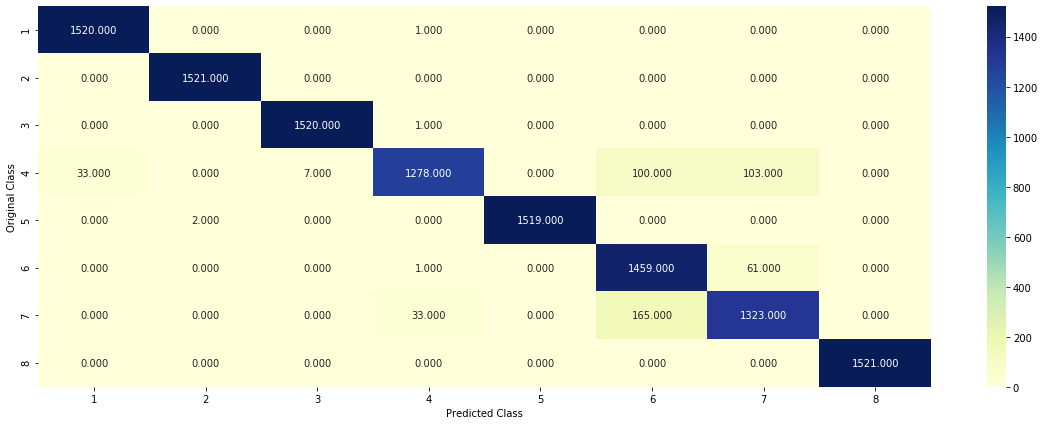

-------------------- Classification report --------------------
              precision    recall  f1-score   support

           0      0.979     0.999     0.989      1521
           1      0.999     1.000     0.999      1521
           2      0.995     0.999     0.997      1521
           3      0.973     0.840     0.902      1521
           4      1.000     0.999     0.999      1521
           5      0.846     0.959     0.899      1521
           6      0.890     0.870     0.880      1521
           7      1.000     1.000     1.000      1521

    accuracy                          0.958     12168
   macro avg      0.960     0.958     0.958     12168
weighted avg      0.960     0.958     0.958     12168

****************************** ROC ******************************


C:\anaconda\envs\PratikEnv\lib\site-packages\sklearn\multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
C:\anaconda\envs\PratikEnv\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


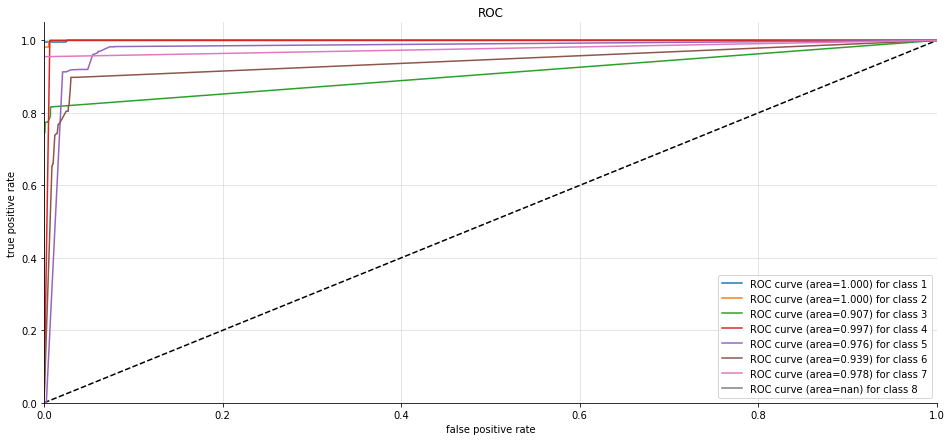

****************************** Precision-Recall curve ******************************


C:\anaconda\envs\PratikEnv\lib\site-packages\sklearn\multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
C:\anaconda\envs\PratikEnv\lib\site-packages\sklearn\metrics\_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


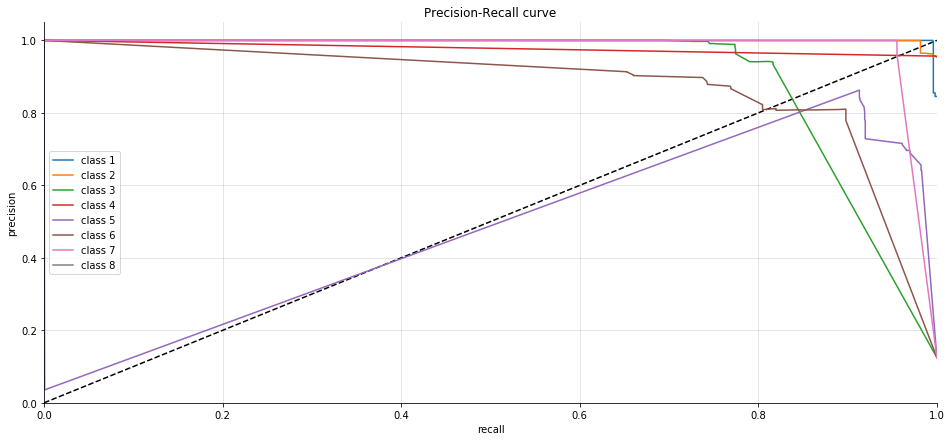

In [39]:
result(classifier=final_model,
       train_x=new_train_x,
       train_y=Y_train,
       test_x=new_test1_x,
       test_y=Y_test,
       pred_y=pred_y1,
       classes=[1,2,3,4,5,6,7,8])

### Test set 2

In [40]:
pred_y2=final_model.predict(new_test2_x)

****************************** Train Set ******************************
-------------------- Classificarion Report --------------------
              precision    recall  f1-score   support

           0      1.000     0.999     0.999      3546
           1      1.000     1.000     1.000      3546
           2      1.000     0.999     0.999      3546
           3      0.998     1.000     0.999      3546
           4      1.000     0.996     0.998      3546
           5      1.000     0.978     0.989      3546
           6      0.978     1.000     0.989      3546
           7      0.996     1.000     0.998      3546

    accuracy                          0.997     28368
   macro avg      0.997     0.997     0.997     28368
weighted avg      0.997     0.997     0.997     28368

****************************** Evaluation on Test set ******************************
f1_score :0.9826704545454545
Number of mis-classified points :1.7329545454545454 %
-------------------- Confusion matrix -------

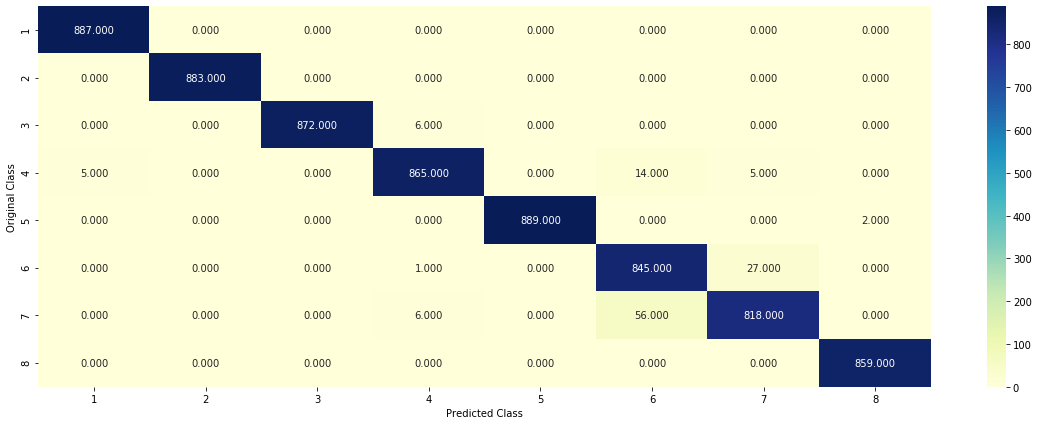

-------------------- Classification report --------------------
              precision    recall  f1-score   support

           0      0.994     1.000     0.997       887
           1      1.000     1.000     1.000       883
           2      1.000     0.993     0.997       878
           3      0.985     0.973     0.979       889
           4      1.000     0.998     0.999       891
           5      0.923     0.968     0.945       873
           6      0.962     0.930     0.946       880
           7      0.998     1.000     0.999       859

    accuracy                          0.983      7040
   macro avg      0.983     0.983     0.983      7040
weighted avg      0.983     0.983     0.983      7040

****************************** ROC ******************************


C:\anaconda\envs\PratikEnv\lib\site-packages\sklearn\multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
C:\anaconda\envs\PratikEnv\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


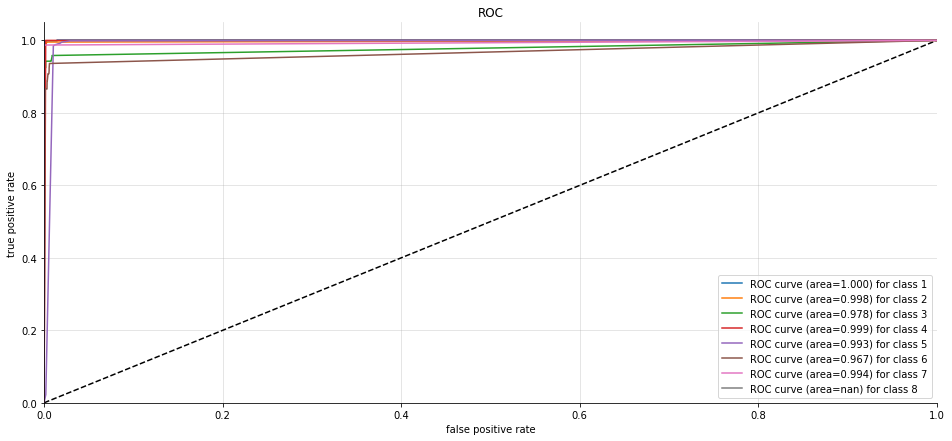

****************************** Precision-Recall curve ******************************


C:\anaconda\envs\PratikEnv\lib\site-packages\sklearn\multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
C:\anaconda\envs\PratikEnv\lib\site-packages\sklearn\metrics\_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


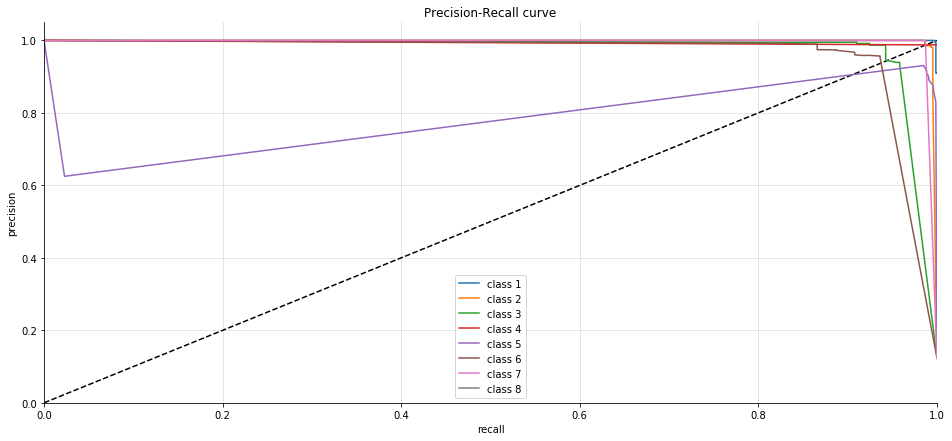

In [41]:
result(classifier=final_model,
       train_x=new_train_x,
       train_y=Y_train,
       test_x=new_test2_x,
       test_y=Y_test2,
       pred_y=pred_y2,
       classes=[1,2,3,4,5,6,7,8])